# فاز 1

##  بارگذاری دیتاست

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # چون ResNet18 ورودی 224x224 می‌خواد
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])  # نرمال‌سازی استاندارد برای مدل‌های pretrained
])
dataset_path = "/content/drive/MyDrive/dataset3"
dataset = ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
print("Classes:", class_names)

# تقسیم train و test
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset.targets)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


Classes: ['cats', 'dogs', 'horses']


## تعریف مدل ResNet18 و استخراج لایه‌ها

In [5]:
import torch.nn as nn
from torchvision import models

# بارگذاری ResNet18 pretrained
resnet = models.resnet18(pretrained=True)

# بدون نیاز به grad چون feature extractor هست
for param in resnet.parameters():
    param.requires_grad = False

# استخراج سه نوع ویژگی:
# 1. ویژگی‌های ابتدایی: تا maxpool
features_low = nn.Sequential(
    resnet.conv1,
    resnet.bn1,
    resnet.relu,
    resnet.maxpool
)

# 2. ویژگی‌های میانی: تا layer2
features_mid = nn.Sequential(
    features_low,
    resnet.layer1,
    resnet.layer2
)

# 3. ویژگی‌های سطح بالا: تا avgpool
features_high = nn.Sequential(
    features_mid,
    resnet.layer3,
    resnet.layer4,
    resnet.avgpool
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
features_low = features_low.to(device)
features_mid = features_mid.to(device)
features_high = features_high.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 50.2MB/s]


## تابع استخراج ویژگی

In [ ]:
!pip install tqdm


In [6]:
from tqdm import tqdm

def extract_features(dataloader, feature_extractor):
    features = []
    labels = []
    feature_extractor.eval()

    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)
            outputs = feature_extractor(images)
            outputs = outputs.view(outputs.size(0), -1)
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())

    X = np.concatenate(features, axis=0)
    y = np.concatenate(labels, axis=0)
    return X, y


In [7]:
# 👇 Train
X_low_tr ,  y_low_tr  = extract_features(train_loader,  features_low)
X_mid_tr ,  y_mid_tr  = extract_features(train_loader,  features_mid)
X_high_tr,  y_high_tr = extract_features(train_loader,  features_high)

# 👇 Test
X_low_te ,  y_low_te  = extract_features(test_loader,   features_low)
X_mid_te ,  y_mid_te  = extract_features(test_loader,   features_mid)
X_high_te,  y_high_te = extract_features(test_loader,   features_high)


Extracting Features: 100%|██████████| 4/4 [00:00<00:00, 30.54it/s]


## آموزش مدل‌های طبقه‌بندی و نتایج هرکدام

In [8]:
# توابع نمایش تحلیل

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def show_confusion_matrix_fixed(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(8, 8))
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(title)
    plt.grid(False)
    plt.show()

def classification_metrics_fixed(y_true, y_pred, class_names):
    print("\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

def evaluate_models_detailed(X_tr, y_tr, X_te, y_te, class_names, title=""):
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.base import clone
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, classification_report, ConfusionMatrixDisplay
    )

    models = {
        "SVM": SVC(probability=True),
        "KNN": KNeighborsClassifier(),
        "Random Forest": RandomForestClassifier(),
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Extra Trees": ExtraTreesClassifier(),
        "Gaussian NB": GaussianNB()
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = {}

    print(f"\n🔍 Evaluation for: {title}\n{'-'*50}")

    for name, model in models.items():
        accuracies, precisions, recalls, f1s = [], [], [], []
        all_y_true, all_y_pred = [], []

        print(f"\nEvaluating {name}...")
        for train_idx, val_idx in tqdm(cv.split(X_tr, y_tr), total=cv.get_n_splits(), desc=f"{name} CV folds"):
            X_train, X_val = X_tr[train_idx], X_tr[val_idx]
            y_train, y_val = y_tr[train_idx], y_tr[val_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

            all_y_true.extend(y_val)
            all_y_pred.extend(y_pred)

            accuracies.append(accuracy_score(y_val, y_pred))
            precisions.append(precision_score(y_val, y_pred, average='weighted', zero_division=0))
            recalls.append(recall_score(y_val, y_pred, average='weighted', zero_division=0))
            f1s.append(f1_score(y_val, y_pred, average='weighted', zero_division=0))

        results[name] = {
            "accuracy_mean": np.mean(accuracies),
            "accuracy_std": np.std(accuracies),
            "precision_mean": np.mean(precisions),
            "recall_mean": np.mean(recalls),
            "f1_mean": np.mean(f1s),
            "y_true": all_y_true,
            "y_pred": all_y_pred
        }

        classification_metrics_fixed(all_y_true, all_y_pred, class_names)
        #show_confusion_matrix_fixed(all_y_true, all_y_pred, class_names, title=f"Confusion Matrix - {name}")

    best_model = max(results.items(), key=lambda x: x[1]['accuracy_mean'])
    print(f"\n🏆 Best model based on Accuracy: **{best_model[0]}** with Accuracy = {best_model[1]['accuracy_mean']:.4f}")

    ## 🔎 گزارش نهایی روی Test
    best_clf = clone(models[best_model[0]])
    best_clf.fit(X_tr, y_tr)
    y_te_pred = best_clf.predict(X_te)

    print(f"\n📌 FINAL TEST REPORT for **{best_model[0]}**")
    classification_metrics_fixed(y_te, y_te_pred, class_names)
    show_confusion_matrix_fixed(y_te, y_te_pred, class_names,
                                title=f"Confusion Matrix (TEST) - {best_model[0]}")




### ویژگی های ابتدایی


🔍 Evaluation for: Low‑Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [19:28<00:00, 233.79s/it]




              precision    recall  f1-score   support

        cats       0.57      0.80      0.67       162
        dogs       0.61      0.43      0.50       161
      horses       0.85      0.75      0.80       161

    accuracy                           0.66       484
   macro avg       0.68      0.66      0.66       484
weighted avg       0.68      0.66      0.66       484


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]




              precision    recall  f1-score   support

        cats       0.42      0.86      0.57       162
        dogs       0.51      0.31      0.39       161
      horses       0.89      0.32      0.47       161

    accuracy                           0.50       484
   macro avg       0.61      0.50      0.47       484
weighted avg       0.61      0.50      0.47       484


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:38<00:00,  7.78s/it]




              precision    recall  f1-score   support

        cats       0.59      0.68      0.63       162
        dogs       0.57      0.50      0.53       161
      horses       0.81      0.79      0.80       161

    accuracy                           0.66       484
   macro avg       0.66      0.66      0.66       484
weighted avg       0.66      0.66      0.66       484


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [02:14<00:00, 26.81s/it]




              precision    recall  f1-score   support

        cats       0.62      0.71      0.66       162
        dogs       0.64      0.54      0.58       161
      horses       0.79      0.79      0.79       161

    accuracy                           0.68       484
   macro avg       0.68      0.68      0.68       484
weighted avg       0.68      0.68      0.68       484


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]




              precision    recall  f1-score   support

        cats       0.61      0.72      0.66       162
        dogs       0.58      0.50      0.53       161
      horses       0.82      0.80      0.81       161

    accuracy                           0.67       484
   macro avg       0.67      0.67      0.67       484
weighted avg       0.67      0.67      0.67       484


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]




              precision    recall  f1-score   support

        cats       0.61      0.72      0.66       162
        dogs       0.55      0.50      0.52       161
      horses       0.76      0.69      0.72       161

    accuracy                           0.64       484
   macro avg       0.64      0.64      0.63       484
weighted avg       0.64      0.64      0.63       484


🏆 Best model based on Accuracy: **Logistic Regression** with Accuracy = 0.6799

📌 FINAL TEST REPORT for **Logistic Regression**


              precision    recall  f1-score   support

        cats       0.62      0.70      0.66        40
        dogs       0.67      0.49      0.56        41
      horses       0.83      0.95      0.89        41

    accuracy                           0.71       122
   macro avg       0.71      0.71      0.70       122
weighted avg       0.71      0.71      0.70       122



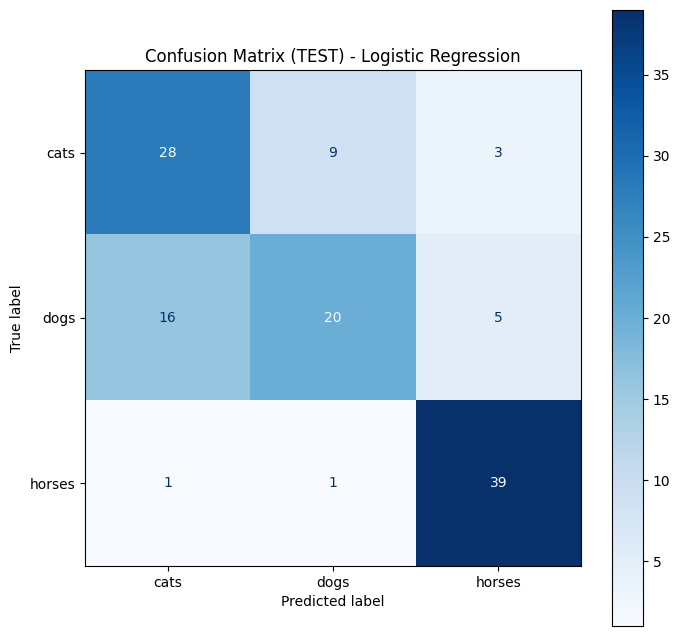

In [15]:
#results_low = evaluate_models_detailed(X_low, y_low, class_names, "Low-Level Features")
results_low = evaluate_models_detailed(X_low_tr, y_low_tr,
                                       X_low_te, y_low_te,
                                       class_names,
                                       "Low‑Level Features")


### ویژگی های میانی


🔍 Evaluation for: mid‑Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [10:43<00:00, 128.61s/it]




              precision    recall  f1-score   support

        cats       0.70      0.79      0.74       162
        dogs       0.66      0.68      0.67       161
      horses       0.96      0.80      0.87       161

    accuracy                           0.76       484
   macro avg       0.77      0.76      0.76       484
weighted avg       0.77      0.76      0.76       484


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]




              precision    recall  f1-score   support

        cats       0.53      0.21      0.30       162
        dogs       0.47      0.42      0.44       161
      horses       0.46      0.78      0.58       161

    accuracy                           0.47       484
   macro avg       0.49      0.47      0.44       484
weighted avg       0.49      0.47      0.44       484


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:20<00:00,  4.14s/it]




              precision    recall  f1-score   support

        cats       0.60      0.67      0.64       162
        dogs       0.55      0.53      0.54       161
      horses       0.87      0.79      0.83       161

    accuracy                           0.67       484
   macro avg       0.67      0.67      0.67       484
weighted avg       0.67      0.67      0.67       484


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [00:31<00:00,  6.26s/it]




              precision    recall  f1-score   support

        cats       0.77      0.87      0.82       162
        dogs       0.78      0.71      0.74       161
      horses       0.93      0.90      0.91       161

    accuracy                           0.83       484
   macro avg       0.83      0.83      0.83       484
weighted avg       0.83      0.83      0.83       484


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:10<00:00,  2.20s/it]




              precision    recall  f1-score   support

        cats       0.60      0.65      0.63       162
        dogs       0.57      0.57      0.57       161
      horses       0.86      0.79      0.82       161

    accuracy                           0.67       484
   macro avg       0.68      0.67      0.67       484
weighted avg       0.68      0.67      0.67       484


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:02<00:00,  1.85it/s]




              precision    recall  f1-score   support

        cats       0.72      0.55      0.62       162
        dogs       0.53      0.81      0.64       161
      horses       0.91      0.66      0.77       161

    accuracy                           0.67       484
   macro avg       0.72      0.67      0.68       484
weighted avg       0.72      0.67      0.68       484


🏆 Best model based on Accuracy: **Logistic Regression** with Accuracy = 0.8265

📌 FINAL TEST REPORT for **Logistic Regression**


              precision    recall  f1-score   support

        cats       0.77      0.90      0.83        40
        dogs       0.85      0.68      0.76        41
      horses       0.95      0.98      0.96        41

    accuracy                           0.85       122
   macro avg       0.86      0.85      0.85       122
weighted avg       0.86      0.85      0.85       122



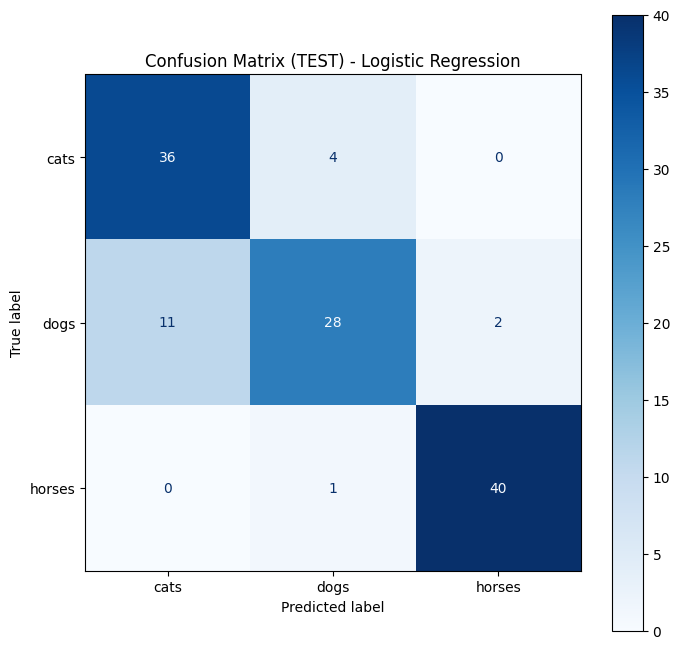

In [16]:
#results_mid = evaluate_models_detailed(X_mid, y_mid, class_names, "Mid-Level Features")
results_mid = evaluate_models_detailed(X_mid_tr, y_mid_tr,
                                       X_mid_te, y_mid_te,
                                       class_names,
                                       "mid‑Level Features")


### ویژگی های سطح بالا


🔍 Evaluation for: High‑Level Features
--------------------------------------------------

Evaluating SVM...


SVM CV folds: 100%|██████████| 5/5 [00:01<00:00,  4.69it/s]




              precision    recall  f1-score   support

        cats       0.98      0.96      0.97       162
        dogs       0.96      0.98      0.97       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484


Evaluating KNN...


KNN CV folds: 100%|██████████| 5/5 [00:00<00:00, 44.63it/s]




              precision    recall  f1-score   support

        cats       0.95      0.97      0.96       162
        dogs       0.97      0.94      0.96       161
      horses       0.99      1.00      1.00       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484


Evaluating Random Forest...


Random Forest CV folds: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]




              precision    recall  f1-score   support

        cats       0.99      0.94      0.97       162
        dogs       0.94      0.99      0.96       161
      horses       0.99      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484


Evaluating Logistic Regression...


Logistic Regression CV folds: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]




              precision    recall  f1-score   support

        cats       0.97      0.96      0.97       162
        dogs       0.96      0.98      0.97       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484


Evaluating Extra Trees...


Extra Trees CV folds: 100%|██████████| 5/5 [00:02<00:00,  2.21it/s]




              precision    recall  f1-score   support

        cats       0.99      0.93      0.96       162
        dogs       0.94      0.99      0.96       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.98       484
   macro avg       0.98      0.98      0.98       484
weighted avg       0.98      0.98      0.98       484


Evaluating Gaussian NB...


Gaussian NB CV folds: 100%|██████████| 5/5 [00:00<00:00, 75.96it/s]




              precision    recall  f1-score   support

        cats       0.98      0.93      0.96       162
        dogs       0.93      0.98      0.96       161
      horses       1.00      1.00      1.00       161

    accuracy                           0.97       484
   macro avg       0.97      0.97      0.97       484
weighted avg       0.97      0.97      0.97       484


🏆 Best model based on Accuracy: **SVM** with Accuracy = 0.9793

📌 FINAL TEST REPORT for **SVM**


              precision    recall  f1-score   support

        cats       1.00      1.00      1.00        40
        dogs       1.00      1.00      1.00        41
      horses       1.00      1.00      1.00        41

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



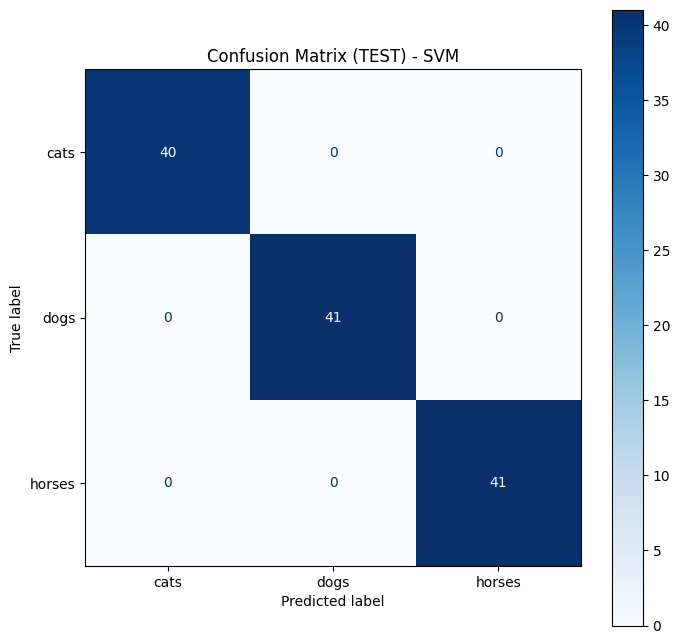

In [17]:
#results_high = evaluate_models_detailed(X_high, y_high, class_names, "High-Level Features")
results_high = evaluate_models_detailed(X_high_tr, y_high_tr,
                                       X_high_te, y_high_te,
                                       class_names,
                                       "High‑Level Features")


# فاز دوم

##with all data

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
# --- 1. ترکیب ویژگی‌ها ---
X = np.concatenate([X_low, X_mid, X_high], axis=1)
# X = np.concatenate([X_mid, X_high], axis=1)
y = y_low  # فرض شده برچسب‌ها در y_low هستن

from sklearn.decomposition import PCA
X_reduced = PCA(n_components=200).fit_transform(X)

# --- 2. تقسیم داده‌ها ---
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:

# --- 3. تعریف و هایپرتیونینگ جداگانه مدل‌های پایه ---

# SVM Pipeline با StandardScaler
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])
svm_params = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear','poly']
}
# svm_params = {
#     'svc__C': [0.1],
#     'svc__gamma': ['auto'],
#     'svc__kernel': ['linear']
# }
# svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=1, random_state=42, n_jobs=-1)
svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=10, random_state=42, n_jobs=-1)
svm_cv.fit(X_train, y_train)
print("Best SVM params:", svm_cv.best_params_)

Best SVM params: {'svc__kernel': 'rbf', 'svc__gamma': 'scale', 'svc__C': 100}


In [ ]:
# Random Forest
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, n_iter=10, random_state=42, n_jobs=-1)
rf_cv.fit(X_train, y_train)
print("Best RF params:", rf_cv.best_params_)

Best RF params: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': 10}


In [ ]:
# Logistic Regression
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga']
}
lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=3, n_iter=6, random_state=42, n_jobs=-1)
lr_cv.fit(X_train, y_train)
print("Best LR params:", lr_cv.best_params_)

Best LR params: {'solver': 'saga', 'penalty': 'l2', 'C': 0.1}


In [ ]:

# Naive Bayes (بدون هایپرتیونینگ)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)


GaussianNB()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_cv = RandomizedSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=3, n_iter=5, random_state=42, n_jobs=-1
)
knn_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'metric': ['euclidean', 'manhattan'],
                                        'n_neighbors': [3, 5, 7],
                                        'weights': ['uniform', 'distance']},
                   random_state=42)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp_cv = RandomizedSearchCV(
    MLPClassifier(max_iter=1000),
    mlp_params,
    cv=3, n_iter=5, random_state=42, n_jobs=-1
)
mlp_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=MLPClassifier(max_iter=1000), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': [0.0001, 0.001],
                                        'hidden_layer_sizes': [(100,),
                                                               (50, 50)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam']},
                   random_state=42)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_cv = RandomizedSearchCV(
    GradientBoostingClassifier(),
    gb_params,
    cv=3, n_iter=5, random_state=42, n_jobs=-1
)
gb_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [50, 100]},
                   random_state=42)

In [ ]:
# --- 4. ساخت مدل‌های پایه با بهترین پارامترها ---

best_svm = svm_cv.best_estimator_
best_rf = rf_cv.best_estimator_
best_lr = lr_cv.best_estimator_
best_gb = gb_cv.best_estimator_
best_mlp = mlp_cv.best_estimator_
best_knn = knn_cv.best_estimator_


In [ ]:

# --- 5. ساخت مدل Stacking ---
base_learners = [
    ('svm', best_svm),
    ('rf', best_rf),
    ('lr', best_lr),
    ('nb', nb_model),
    ('knn', best_knn),
    ('mlp', best_mlp),
    ('gb', best_gb)
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# --- 6. آموزش مدل Stacking ---
stacking_clf.fit(X_train, y_train)


StackingClassifier(cv=5,
                   estimators=[('svm',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('svc',
                                                 SVC(C=100,
                                                     probability=True))])),
                               ('rf',
                                RandomForestClassifier(max_depth=10,
                                                       n_estimators=150,
                                                       random_state=42)),
                               ('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42,
                                                   solver='saga')),
                               ('nb', GaussianNB()),
                               ('knn',
                                KNeighborsClassifier(metric='euclidean',
                                                     n_neighbors=7,
                                                     weights='distance')),
                               ('mlp',
                                MLPClassifier(activation='tanh', alpha=0.001,
                                              hidden_layer_sizes=(50, 50),
                                              max_iter=1000)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42),
                   n_jobs=-1)


📊 [Train] Accuracy: 1.0
📊 [Train] Classification Report:
              precision    recall  f1-score   support

        cats       1.00      1.00      1.00       129
        dogs       1.00      1.00      1.00       135
      horses       1.00      1.00      1.00       129

    accuracy                           1.00       393
   macro avg       1.00      1.00      1.00       393
weighted avg       1.00      1.00      1.00       393

🔍 Accuracy: 0.6262626262626263
🔍 Precision (macro): 0.6499032133178474
🔍 Recall (macro): 0.6278223410576352
🔍 F1 Score (macro): 0.6334680739576316

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.62      0.55        32
           1       0.53      0.47      0.50        34
           2       0.93      0.79      0.85        33

    accuracy                           0.63        99
   macro avg       0.65      0.63      0.63        99
weighted avg       0.65      0.63      0.63        99



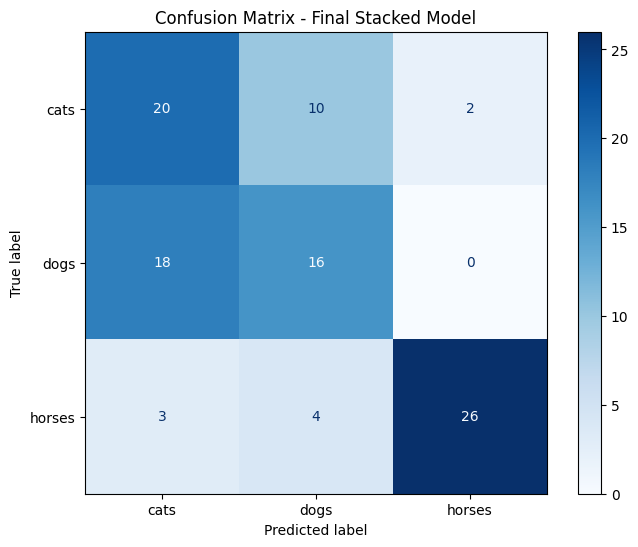

In [ ]:

# 🔍 ارزیابی روی داده‌های آموزش
y_train_pred = stacking_clf.predict(X_train)

print("\n📊 [Train] Accuracy:", accuracy_score(y_train, y_train_pred))
print("📊 [Train] Classification Report:")
print(classification_report(y_train, y_train_pred, target_names=class_names))

# --- 7. ارزیابی نهایی ---
y_pred = stacking_clf.predict(X_test)

print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("🔍 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("🔍 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("🔍 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Final Stacked Model")
plt.grid(False)
plt.show()


##ترکیب فاز یک و دو

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import numpy as np

# فرض: سه نوع ویژگی داری و برچسب‌ها
# X_low, X_mid, X_high, y

# تقسیم به train/test
X_low_train, X_low_test, y_train, y_test = train_test_split(X_low, y_low, test_size=0.2, random_state=42, stratify=y_low)
X_mid_train, X_mid_test = train_test_split(X_mid, test_size=0.2, random_state=42, stratify=y_low)[0:2]
X_high_train, X_high_test = train_test_split(X_high, test_size=0.2, random_state=42, stratify=y_low)[0:2]

# تعریف base learners برای آموزش جداگانه
lr_low = LogisticRegression(max_iter=1000)
lr_mid = LogisticRegression(max_iter=1000)
lr_high = LogisticRegression(max_iter=1000)
rf_low = RandomForestClassifier()
svm_mid = SVC(probability=True)

# گرفتن خروجی احتمالاتی از base learners با cross_val_predict (کاهش data leakage)
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# گرفتن پیش‌بینی‌های OOF برای هر base learner روی داده آموزش
proba_lr_low  = cross_val_predict(lr_low,  X_low_train,  y_train, cv=cv, method='predict_proba')
proba_lr_mid  = cross_val_predict(lr_mid,  X_mid_train,  y_train, cv=cv, method='predict_proba')
proba_lr_high = cross_val_predict(lr_high, X_high_train, y_train, cv=cv, method='predict_proba')
proba_rf_low  = cross_val_predict(rf_low,  X_low_train,  y_train, cv=cv, method='predict_proba')
proba_svm_mid = cross_val_predict(svm_mid, X_mid_train,  y_train, cv=cv, method='predict_proba')

# ترکیب ویژگی‌های پیش‌بینی‌شده برای ساخت داده ورودی به meta-model
X_meta_train = np.hstack([proba_lr_low, proba_lr_mid, proba_lr_high, proba_rf_low, proba_svm_mid])

# آموزش meta-model
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(X_meta_train, y_train)

# حالا base مدل‌ها رو روی کل داده آموزش  تا روی تست هم بتونیم پیش‌بینی کنیم
lr_low.fit(X_low_train, y_train)
lr_mid.fit(X_mid_train, y_train)
lr_high.fit(X_high_train, y_train)
rf_low.fit(X_low_train, y_train)
svm_mid.fit(X_mid_train, y_train)

# پیش‌بینی احتمالاتی روی test
proba_lr_low_test  = lr_low.predict_proba(X_low_test)
proba_lr_mid_test  = lr_mid.predict_proba(X_mid_test)
proba_lr_high_test = lr_high.predict_proba(X_high_test)
proba_rf_low_test  = rf_low.predict_proba(X_low_test)
proba_svm_mid_test = svm_mid.predict_proba(X_mid_test)

# ساخت ویژگی‌های تست برای meta-model
X_meta_test = np.hstack([proba_lr_low_test, proba_lr_mid_test, proba_lr_high_test,
                         proba_rf_low_test, proba_svm_mid_test])

# پیش‌بینی نهایی
final_preds = meta_model.predict(X_meta_test)


# گزارش نهایی
print(classification_report(y_test, final_preds))


              precision    recall  f1-score   support

           0       0.65      0.79      0.71        33
           1       0.67      0.56      0.61        32
           2       0.90      0.84      0.87        32

    accuracy                           0.73        97
   macro avg       0.74      0.73      0.73        97
weighted avg       0.74      0.73      0.73        97



Test Accuracy: 0.7320
Train Accuracy: 0.7209


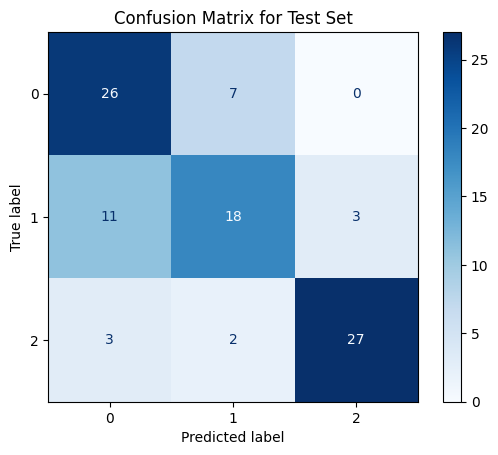

In [ ]:
from sklearn.metrics import accuracy_score

# دقت روی داده تست
accuracy_test = accuracy_score(y_test, final_preds)
print(f"Test Accuracy: {accuracy_test:.4f}")

# دقت روی داده آموزش
train_preds = meta_model.predict(X_meta_train)
accuracy_train = accuracy_score(y_train, train_preds)
print(f"Train Accuracy: {accuracy_train:.4f}")
# ماتریس سردرگمی روی داده تست
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()

In [ ]:
from sklearn.ensemble import StackingClassifier

stacking_model = StackingClassifier(
    estimators=[
        ('lr_low', lr_low),
        ('lr_mid', lr_mid),
        ('lr_high', lr_high),
        ('rf_low', rf_low),
        ('svm_mid', svm_mid)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5,
    passthrough=False  # اگر بخوای ویژگی‌های اصلی هم وارد meta-model بشن، بذار True
)

# ساخت یک داده ترکیبی برای همه ویژگی‌ها (مثلاً concatenate)
X_train_combined = np.hstack([X_low_train, X_mid_train, X_high_train])
X_test_combined = np.hstack([X_low_test, X_mid_test, X_high_test])

# آموزش و پیش‌بینی
stacking_model.fit(X_train_combined, y_train)
final_preds = stacking_model.predict(X_test_combined)

print(classification_report(y_test, final_preds))


              precision    recall  f1-score   support

           0       0.61      0.76      0.68        33
           1       0.60      0.47      0.53        32
           2       0.87      0.84      0.86        32

    accuracy                           0.69        97
   macro avg       0.69      0.69      0.69        97
weighted avg       0.69      0.69      0.69        97



Test Accuracy: 0.6907
Train Accuracy: 0.7209


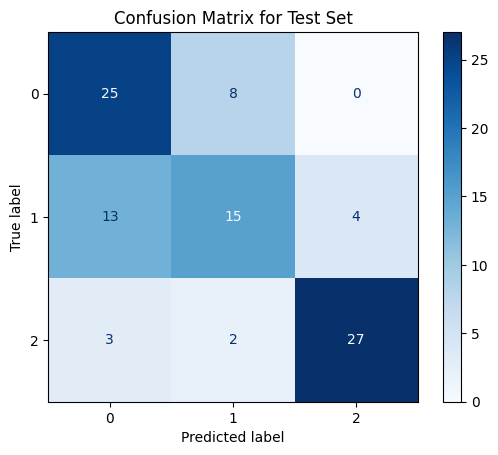

In [ ]:
# دقت روی داده تست
accuracy_test = accuracy_score(y_test, final_preds)
print(f"Test Accuracy: {accuracy_test:.4f}")

# دقت روی داده آموزش
train_preds = meta_model.predict(X_meta_train)
accuracy_train = accuracy_score(y_train, train_preds)
print(f"Train Accuracy: {accuracy_train:.4f}")
# ماتریس سردرگمی روی داده تست
cm = confusion_matrix(y_test, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()

###x_low

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

X_low, y_low = extract_features(train_loader, features_low)
X = X_low
y = y_low


from sklearn.decomposition import PCA
X = PCA(n_components=40).fit_transform(X)

# تبدیل برچسب‌ها به binary برای رسم ROC
y_bin = label_binarize(y, classes=np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- SVM ---
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])
svm_params = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear']
}
svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=6, random_state=42)

# --- Random Forest ---
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_cv = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=6, random_state=42)

# --- Logistic Regression ---
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_iter=6, random_state=42)

# --- Naive Bayes ---
nb_model = GaussianNB()

from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_cv = RandomizedSearchCV(KNeighborsClassifier(),knn_params,cv=3, n_iter=6, random_state=42)

from sklearn.neural_network import MLPClassifier
mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp_cv = RandomizedSearchCV(MLPClassifier(max_iter=1000), mlp_params,cv=3, n_iter=6, random_state=42)

from sklearn.ensemble import GradientBoostingClassifier
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_cv = RandomizedSearchCV(GradientBoostingClassifier(),gb_params,cv=3, n_iter=5, random_state=42)

base_learners = [
    ('svm', svm_cv),
    ('rf', rf_cv),
    ('lr', lr_cv),
    ('nb', nb_model),
    ('knn', knn_cv),
    ('mlp', mlp_cv),
    # ('gb', gb_cv)
]
meta_model = LogisticRegression(max_iter=1000)

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,  # CV برای کاهش overfitting در لایه meta
    n_jobs=-1,
    passthrough=False
)

stack_clf.fit(X_train, y_train)

# 5. پیش‌بینی و ارزیابی
y_pred = stack_clf.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("🔍 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("🔍 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("🔍 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# دقت روی داده آموزش
train_preds = stack_clf.predict(X_train)
accuracy_train = accuracy_score(y_train, train_preds)
print(f"Train Accuracy: {accuracy_train:.4f}")

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Stacked Model")
plt.grid(False)
plt.show()

# 7. ROC Curve (multi-class)
if len(np.unique(y)) == 3:
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    y_score = stack_clf.predict_proba(X_test)
    RocCurveDisplay.from_predictions(y_test_bin.ravel(), y_score.ravel())
    plt.title("Multi-Class ROC Curve")
    plt.show()

# # 8. Learning Curve
# train_sizes, train_scores, test_scores = learning_curve(
#     stack_clf, X, y, cv=StratifiedKFold(5), n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
# )

# train_mean = train_scores.mean(axis=1)
# test_mean = test_scores.mean(axis=1)

# plt.plot(train_sizes, train_mean, 'o-', label='Train Accuracy')
# plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
# plt.xlabel('Training Set Size')
# plt.ylabel('Accuracy')
# plt.title('Learning Curve - Stacked Model')
# plt.legend()
# plt.grid(True)
# plt.show()


Extracting Features: 100%|██████████| 16/16 [00:01<00:00, 11.64it/s]


KeyboardInterrupt: 

###x_mid

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

X_mid, y_mid = extract_features(train_loader, features_mid)
X = X_mid
y = y_mid  # برچسب‌ها

from sklearn.decomposition import PCA
X = PCA(n_components=40).fit_transform(X)

# تبدیل برچسب‌ها به binary برای رسم ROC (در صورت نیاز)
y_bin = label_binarize(y, classes=np.unique(y))

# 1. تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. تعریف مدل‌ها با Hypertuning
# --- SVM ---
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])
svm_params = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear']
}
svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=6, random_state=42)

# --- Random Forest ---
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_cv = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=6, random_state=42)

# --- Logistic Regression ---
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_iter=6, random_state=42)

# --- Naive Bayes ---
nb_model = GaussianNB()
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_cv = RandomizedSearchCV(KNeighborsClassifier(),knn_params,cv=3, n_iter=6, random_state=42)

from sklearn.neural_network import MLPClassifier
mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp_cv = RandomizedSearchCV(MLPClassifier(max_iter=1000), mlp_params,cv=3, n_iter=6, random_state=42)

from sklearn.ensemble import GradientBoostingClassifier
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_cv = RandomizedSearchCV(GradientBoostingClassifier(),gb_params,cv=3, n_iter=5, random_state=42)

# 3. تعریف StackingClassifier با Cross-Validation داخلی
base_learners = [
    ('svm', svm_cv),
    ('rf', rf_cv),
    ('lr', lr_cv),
    ('nb', nb_model),
    ('knn', knn_cv),
    ('mlp', mlp_cv),
    # ('gb', gb_cv)
]
meta_model = LogisticRegression(max_iter=1000)

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,  # CV برای کاهش overfitting در لایه meta
    n_jobs=-1,
    passthrough=False
)


# 4. آموزش مدل
stack_clf.fit(X_train, y_train)



In [ ]:

# 5. پیش‌بینی و ارزیابی
y_pred = stack_clf.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("🔍 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("🔍 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("🔍 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
# دقت روی داده آموزش
train_preds = stack_clf.predict(X_train)
accuracy_train = accuracy_score(y_train, train_preds)
print(f"Train Accuracy: {accuracy_train:.4f}")

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Stacked Model")
plt.grid(False)
plt.show()

# 7. ROC Curve (multi-class)
if len(np.unique(y)) == 3:
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    y_score = stack_clf.predict_proba(X_test)
    RocCurveDisplay.from_predictions(y_test_bin.ravel(), y_score.ravel())
    plt.title("Multi-Class ROC Curve")
    plt.show()

# # 8. Learning Curve
# train_sizes, train_scores, test_scores = learning_curve(
#     stack_clf, X, y, cv=StratifiedKFold(5), n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
# )

# train_mean = train_scores.mean(axis=1)
# test_mean = test_scores.mean(axis=1)

# plt.plot(train_sizes, train_mean, 'o-', label='Train Accuracy')
# plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
# plt.xlabel('Training Set Size')
# plt.ylabel('Accuracy')
# plt.title('Learning Curve - Stacked Model')
# plt.legend()
# plt.grid(True)
# plt.show()

###x_high

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

# فرض: X_low, X_mid, X_high و y قبلاً آماده شده‌اند.
# X = np.concatenate([X_low, X_mid, X_high], axis=1)

X_high, y_high = extract_features(train_loader, features_high)
X = X_high
y = y_high


# from sklearn.decomposition import PCA
# X = PCA(n_components=200).fit_transform(X)

# تبدیل برچسب‌ها به binary برای رسم ROC (در صورت نیاز)
y_bin = label_binarize(y, classes=np.unique(y))

# 1. تقسیم داده
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 2. تعریف مدل‌ها با Hypertuning
# --- SVM ---
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])
svm_params = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['rbf', 'linear']
}
svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=6, random_state=42)

# --- Random Forest ---
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
rf_cv = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=6, random_state=42)

# --- Logistic Regression ---
lr_params = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}
lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_iter=6, random_state=42)

# --- Naive Bayes ---
nb_model = GaussianNB()

# 3. تعریف StackingClassifier با Cross-Validation داخلی
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_cv = RandomizedSearchCV(KNeighborsClassifier(),knn_params,cv=3, n_iter=6, random_state=42)

from sklearn.neural_network import MLPClassifier
mlp_params = {
    'hidden_layer_sizes': [(100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}
mlp_cv = RandomizedSearchCV(MLPClassifier(max_iter=1000), mlp_params,cv=3, n_iter=6, random_state=42)

from sklearn.ensemble import GradientBoostingClassifier
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
gb_cv = RandomizedSearchCV(GradientBoostingClassifier(),gb_params,cv=3, n_iter=5, random_state=42)

# 3. تعریف StackingClassifier با Cross-Validation داخلی
base_learners = [
    ('svm', svm_cv),
    ('rf', rf_cv),
    ('lr', lr_cv),
    ('nb', nb_model),
    ('knn', knn_cv),
    ('mlp', mlp_cv),
    # ('gb', gb_cv)
]
meta_model = LogisticRegression(max_iter=1000)

stack_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_model,
    cv=5,  # CV برای کاهش overfitting در لایه meta
    n_jobs=-1,
    passthrough=False
)

# 4. آموزش مدل
stack_clf.fit(X_train, y_train)

# 5. پیش‌بینی و ارزیابی
y_pred = stack_clf.predict(X_test)
print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
print("🔍 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("🔍 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("🔍 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# دقت روی داده آموزش
train_preds = stack_clf.predict(X_train)
accuracy_train = accuracy_score(y_train, train_preds)
print(f"Train Accuracy: {accuracy_train:.4f}")

# 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Stacked Model")
plt.grid(False)
plt.show()

# 7. ROC Curve (multi-class)
if len(np.unique(y)) == 3:
    y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
    y_score = stack_clf.predict_proba(X_test)
    RocCurveDisplay.from_predictions(y_test_bin.ravel(), y_score.ravel())
    plt.title("Multi-Class ROC Curve")
    plt.show()

# # 8. Learning Curve
# train_sizes, train_scores, test_scores = learning_curve(
#     stack_clf, X, y, cv=StratifiedKFold(5), n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
# )

# train_mean = train_scores.mean(axis=1)
# test_mean = test_scores.mean(axis=1)

# plt.plot(train_sizes, train_mean, 'o-', label='Train Accuracy')
# plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
# plt.xlabel('Training Set Size')
# plt.ylabel('Accuracy')
# plt.title('Learning Curve - Stacked Model')
# plt.legend()
# plt.grid(True)
# plt.show()



##با کتابخانه

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay
)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedKFold

def stack(train , test):
  X = train
  y = test
  # تبدیل برچسب‌ها به binary برای رسم ROC (در صورت نیاز)
  y_bin = label_binarize(y, classes=np.unique(y))

  # 1. تقسیم داده
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

  # 2. تعریف مدل‌ها با Hypertuning
  # --- SVM ---
  svm_pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ('svc', SVC(probability=True))
  ])
  svm_params = {
      'svc__C': [0.1, 1, 10],
      'svc__gamma': ['scale', 'auto'],
      'svc__kernel': ['rbf', 'linear']
  }
  svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=6, random_state=42)

  # --- Random Forest ---
  rf_params = {
      'n_estimators': [50, 100, 150],
      'max_depth': [None, 10, 20],
      'min_samples_split': [2, 5]
  }
  rf_cv = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=6, random_state=42)

  # --- Logistic Regression ---
  lr_params = {
      'C': [0.1, 1, 10],
      'penalty': ['l2'],
      'solver': ['liblinear']
  }
  lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_iter=6, random_state=42)

  # --- Naive Bayes ---
  nb_model = GaussianNB()

  # 3. تعریف StackingClassifier با Cross-Validation داخلی
  from sklearn.neighbors import KNeighborsClassifier

  knn_params = {
      'n_neighbors': [3, 5, 7],
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }
  knn_cv = RandomizedSearchCV(KNeighborsClassifier(),knn_params,cv=3, n_iter=6, random_state=42)

  from sklearn.neural_network import MLPClassifier
  mlp_params = {
      'hidden_layer_sizes': [(100,), (50, 50)],
      'activation': ['relu', 'tanh'],
      'solver': ['adam'],
      'alpha': [0.0001, 0.001],
      'learning_rate': ['constant', 'adaptive']
  }
  mlp_cv = RandomizedSearchCV(MLPClassifier(max_iter=1000), mlp_params,cv=3, n_iter=6, random_state=42)

  from sklearn.ensemble import GradientBoostingClassifier
  gb_params = {
      'n_estimators': [50, 100],
      'learning_rate': [0.05, 0.1],
      'max_depth': [3, 5]
  }
  gb_cv = RandomizedSearchCV(GradientBoostingClassifier(),gb_params,cv=3, n_iter=5, random_state=42)

  # 3. تعریف StackingClassifier با Cross-Validation داخلی
  base_learners = [
      ('svm', svm_cv),
      ('rf', rf_cv),
      ('lr', lr_cv),
      ('nb', nb_model),
      ('knn', knn_cv),
      ('mlp', mlp_cv),
      # ('gb', gb_cv)
  ]
  meta_model = LogisticRegression(max_iter=1000)

  stack_clf = StackingClassifier(
      estimators=base_learners,
      final_estimator=meta_model,
      cv=5,  # CV برای کاهش overfitting در لایه meta
      n_jobs=-1,
      passthrough=False
  )

  # 4. آموزش مدل
  stack_clf.fit(X_train, y_train)

  # 5. پیش‌بینی و ارزیابی
  y_pred = stack_clf.predict(X_test)
  print("🔍 Accuracy:", accuracy_score(y_test, y_pred))
  print("🔍 Precision (macro):", precision_score(y_test, y_pred, average='macro'))
  print("🔍 Recall (macro):", recall_score(y_test, y_pred, average='macro'))
  print("🔍 F1 Score (macro):", f1_score(y_test, y_pred, average='macro'))
  print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

  # دقت روی داده آموزش
  train_preds = stack_clf.predict(X_train)
  accuracy_train = accuracy_score(y_train, train_preds)
  print(f"Train Accuracy: {accuracy_train:.4f}")

  # 6. Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap='Blues', values_format='d')
  plt.title("Confusion Matrix - Stacked Model")
  plt.grid(False)
  plt.show()

  # 7. ROC Curve (multi-class)
  if len(np.unique(y)) == 3:
      y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
      y_score = stack_clf.predict_proba(X_test)
      RocCurveDisplay.from_predictions(y_test_bin.ravel(), y_score.ravel())
      plt.title("Multi-Class ROC Curve")
      plt.show()

  # # 8. Learning Curve
  # train_sizes, train_scores, test_scores = learning_curve(
  #     stack_clf, X, y, cv=StratifiedKFold(5), n_jobs=-1,
  #     train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
  # )

  # train_mean = train_scores.mean(axis=1)
  # test_mean = test_scores.mean(axis=1)

  # plt.plot(train_sizes, train_mean, 'o-', label='Train Accuracy')
  # plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
  # plt.xlabel('Training Set Size')
  # plt.ylabel('Accuracy')
  # plt.title('Learning Curve - Stacked Model')
  # plt.legend()
  # plt.grid(True)
  # plt.show()



###x_high

Extracting Features: 100%|██████████| 16/16 [00:00<00:00, 27.36it/s]


🔍 Accuracy: 1.0
🔍 Precision (macro): 1.0
🔍 Recall (macro): 1.0
🔍 F1 Score (macro): 1.0

📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        34
           2       1.00      1.00      1.00        33

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99

Train Accuracy: 1.0000


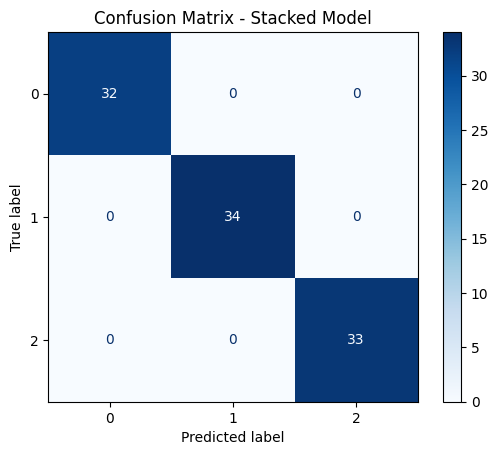

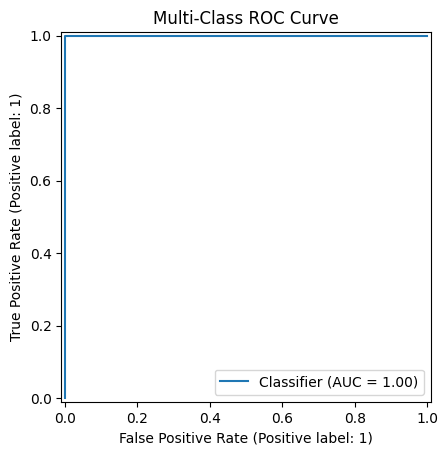

In [ ]:

X_high, y_high = extract_features(train_loader, features_high)
stack(X_high, y_high)

###x_mid

Extracting Features: 100%|██████████| 16/16 [00:00<00:00, 31.38it/s]


🔍 Accuracy: 0.8080808080808081
🔍 Precision (macro): 0.8044173205463528
🔍 Recall (macro): 0.8085264408793821
🔍 F1 Score (macro): 0.8048840048840048

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76        32
           1       0.77      0.71      0.74        34
           2       0.86      0.97      0.91        33

    accuracy                           0.81        99
   macro avg       0.80      0.81      0.80        99
weighted avg       0.80      0.81      0.80        99

Train Accuracy: 0.9949


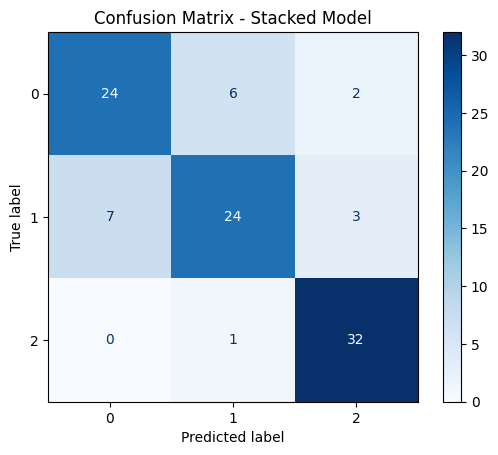

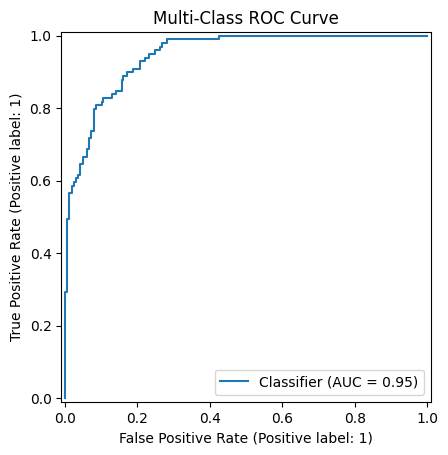

In [ ]:
X_mid, y_mid = extract_features(train_loader, features_mid)
from sklearn.decomposition import PCA
X = PCA(n_components=40).fit_transform(X_mid)

stack(X , y_mid)

###x_low

Extracting Features: 100%|██████████| 16/16 [00:00<00:00, 48.87it/s]


🔍 Accuracy: 0.7171717171717171
🔍 Precision (macro): 0.7122315592903828
🔍 Recall (macro): 0.7169303327391563
🔍 F1 Score (macro): 0.7141049968374446

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61        32
           1       0.62      0.62      0.62        34
           2       0.89      0.94      0.91        33

    accuracy                           0.72        99
   macro avg       0.71      0.72      0.71        99
weighted avg       0.71      0.72      0.71        99

Train Accuracy: 0.9975


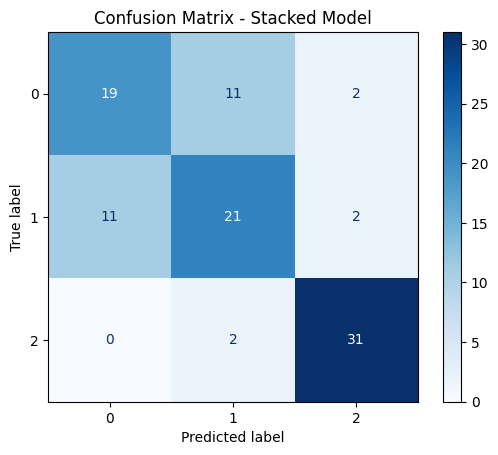

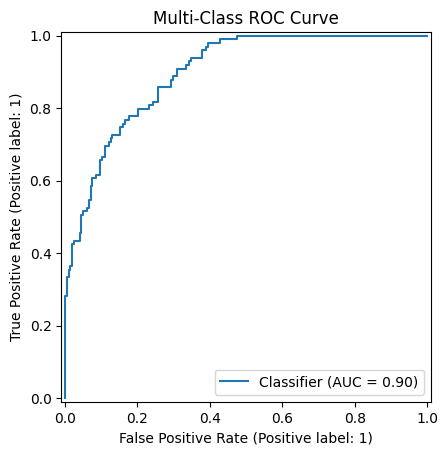

In [ ]:
X_low, y_low = extract_features(train_loader, features_low)
X_test, y_test = extract_features(test_loader, features_low)
from sklearn.decomposition import PCA
X = PCA(n_components=40).fit_transform(X_low)
stack(X,X_test ,  y_low , y_test)

## دستی

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
import numpy as np
def stack_handy(X , y):
  # تقسیم به train/test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  # 2. تعریف مدل‌ها با Hypertuning
  # --- SVM ---
  svm_pipeline = Pipeline([
      ('scaler', StandardScaler()),
      ('svc', SVC(probability=True))
  ])
  svm_params = {
      'svc__C': [0.1, 1, 10],
      'svc__gamma': ['scale', 'auto'],
      'svc__kernel': ['rbf', 'linear']
  }
  svm_cv = RandomizedSearchCV(svm_pipeline, svm_params, cv=3, n_iter=6, random_state=42)

  # --- Random Forest ---
  rf_params = {
      'n_estimators': [50, 100, 150],
      'max_depth': [None, 10, 20],
      'min_samples_split': [2, 5]
  }
  rf_cv = RandomizedSearchCV(RandomForestClassifier(), rf_params, cv=3, n_iter=6, random_state=42)

  # --- Logistic Regression ---
  lr_params = {
      'C': [0.1, 1, 10],
      'penalty': ['l2'],
      'solver': ['liblinear']
  }
  lr_cv = RandomizedSearchCV(LogisticRegression(max_iter=1000), lr_params, cv=3, n_iter=6, random_state=42)

  # --- Naive Bayes ---
  nb_model = GaussianNB()

  from sklearn.neighbors import KNeighborsClassifier

  knn_params = {
      'n_neighbors': [3, 5, 7],
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan']
  }
  knn_cv = RandomizedSearchCV(KNeighborsClassifier(),knn_params,cv=3, n_iter=6, random_state=42)

  from sklearn.neural_network import MLPClassifier
  mlp_params = {
      'hidden_layer_sizes': [(100,), (50, 50)],
      'activation': ['relu', 'tanh'],
      'solver': ['adam'],
      'alpha': [0.0001, 0.001],
      'learning_rate': ['constant', 'adaptive']
  }
  mlp_cv = RandomizedSearchCV(MLPClassifier(max_iter=1000), mlp_params,cv=3, n_iter=6, random_state=42)

  from sklearn.ensemble import GradientBoostingClassifier
  gb_params = {
      'n_estimators': [50, 100],
      'learning_rate': [0.05, 0.1],
      'max_depth': [3, 5]
  }
  gb_cv = RandomizedSearchCV(GradientBoostingClassifier(),gb_params,cv=3, n_iter=6, random_state=42)

  # 3. تعریف StackingClassifier با Cross-Validation داخلی
  base_learners = [
      ('svm', svm_cv),
      ('rf', rf_cv),
      ('lr', lr_cv),
      ('nb', nb_model),
      ('knn', knn_cv),
      ('mlp', mlp_cv),
      # ('gb', gb_cv)
  ]

  # گرفتن خروجی احتمالاتی از base learners با cross_val_predict (کاهش data leakage)
  from sklearn.model_selection import StratifiedKFold
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

  # گرفتن پیش‌بینی‌های OOF برای هر base learner روی داده آموزش
  proba_svm  = cross_val_predict(svm_cv,  X_train,  y_train, cv=cv, method='predict_proba')
  proba_rf  = cross_val_predict(rf_cv,  X_train,  y_train, cv=cv, method='predict_proba')
  proba_lr = cross_val_predict(lr_cv, X_train, y_train, cv=cv, method='predict_proba')
  proba_nb  = cross_val_predict(nb_model,  X_train,  y_train, cv=cv, method='predict_proba')
  proba_knn = cross_val_predict(knn_cv, X_train,  y_train, cv=cv, method='predict_proba')
  proba_mlp = cross_val_predict(mlp_cv, X_train,  y_train, cv=cv, method='predict_proba')

  # ترکیب ویژگی‌های پیش‌بینی‌شده برای ساخت داده ورودی به meta-model
  X_meta_train = np.hstack([proba_svm ,proba_rf ,proba_lr, proba_nb,  proba_knn, proba_mlp])

  # آموزش meta-model
  meta_model = LogisticRegression(max_iter=1000)
  meta_model.fit(X_meta_train, y_train)

  # حالا base مدل‌ها رو روی کل داده آموزش  تا روی تست هم بتونیم پیش‌بینی کنیم
  svm_cv.fit(X_train, y_train)
  rf_cv.fit(X_train, y_train)
  lr_cv.fit(X_train, y_train)
  nb_model.fit(X_train, y_train)
  knn_cv.fit(X_train, y_train)
  mlp_cv.fit(X_train, y_train)

  # پیش‌بینی احتمالاتی روی test
  proba_svm_test  = svm_cv.predict_proba(X_test)
  proba_rf_test  = rf_cv.predict_proba(X_test)
  proba_lr_test = lr_cv.predict_proba(X_test)
  proba_nb_test  = nb_model.predict_proba(X_test)
  proba_knn_test = knn_cv.predict_proba(X_test)
  proba_mlp_test = mlp_cv.predict_proba(X_test)
  # ساخت ویژگی‌های تست برای meta-model
  X_meta_test = np.hstack([  proba_svm_test ,proba_rf_test  ,proba_lr_test,proba_nb_test ,proba_knn_test,proba_mlp_test ])

  # پیش‌بینی نهایی
  final_preds = meta_model.predict(X_meta_test)


  # گزارش نهایی
  print(classification_report(y_test, final_preds))
  from sklearn.metrics import accuracy_score

  # دقت روی داده تست
  accuracy_test = accuracy_score(y_test, final_preds)
  print(f"Test Accuracy: {accuracy_test:.4f}")

  # دقت روی داده آموزش
  train_preds = meta_model.predict(X_meta_train)
  accuracy_train = accuracy_score(y_train, train_preds)
  print(f"Train Accuracy: {accuracy_train:.4f}")


  # ماتریس سردرگمی روی داده تست
  cm = confusion_matrix(y_test, final_preds)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(cmap=plt.cm.Blues)
  plt.title("Confusion Matrix for Test Set")
  plt.show()

###low

Extracting Features: 100%|██████████| 16/16 [00:00<00:00, 53.58it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(

              precision    recall  f1-score   support

           0       0.61      0.62      0.62        32
           1       0.59      0.59      0.59        34
           2       0.88      0.85      0.86        33

    accuracy                           0.69        99
   macro avg       0.69      0.69      0.69        99
weighted avg       0.69      0.69      0.69        99

Test Accuracy: 0.6869
Train Accuracy: 0.7125


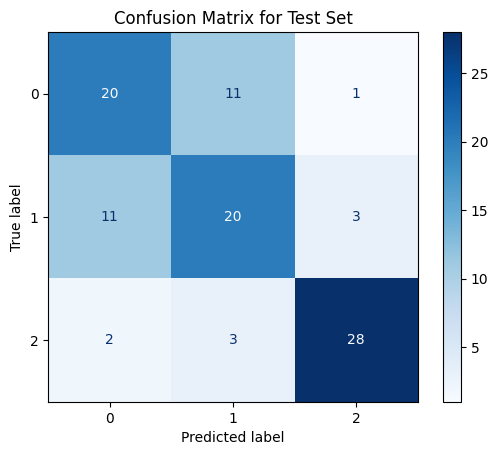

In [ ]:
X_low, y_low = extract_features(train_loader, features_low)
from sklearn.decomposition import PCA
X_low = PCA(n_components=40).fit_transform(X_low)
stack_handy(X_low , y_low)

###mid

Extracting Features: 100%|██████████| 16/16 [00:00<00:00, 29.43it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(

              precision    recall  f1-score   support

           0       0.80      0.75      0.77        32
           1       0.73      0.79      0.76        34
           2       0.97      0.94      0.95        33

    accuracy                           0.83        99
   macro avg       0.83      0.83      0.83        99
weighted avg       0.83      0.83      0.83        99

Test Accuracy: 0.8283
Train Accuracy: 0.8448


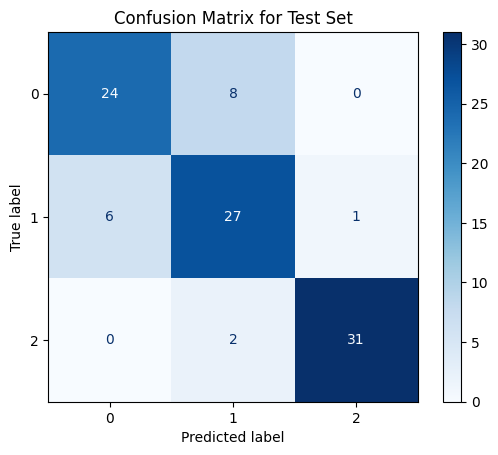

In [ ]:

X_mid, y_mid = extract_features(train_loader, features_mid)
from sklearn.decomposition import PCA
X_mid = PCA(n_components=40).fit_transform(X_mid)
stack_handy(X_mid , y_mid)

###high

Extracting Features: 100%|██████████| 16/16 [00:00<00:00, 19.62it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=6. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        32
           1       0.92      1.00      0.96        34
           2       1.00      1.00      1.00        33

    accuracy                           0.97        99
   macro avg       0.97      0.97      0.97        99
weighted avg       0.97      0.97      0.97        99

Test Accuracy: 0.9697
Train Accuracy: 0.9898


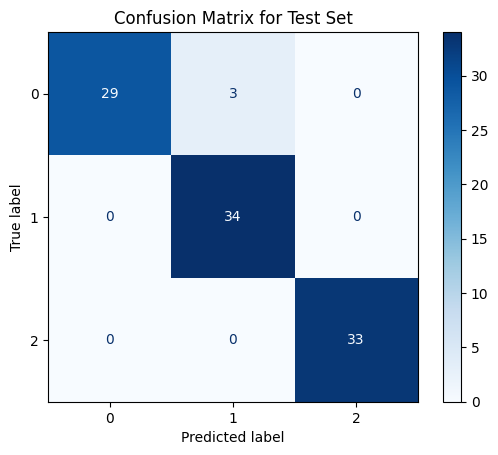

In [ ]:

X_high, y_high = extract_features(train_loader, features_high)
stack_handy(X_high , y_high)